# Machine Learning project : Ensemble optimisation using hyperparameter and architecture search

## Part 1(A) - Describing the data set :

The Data set has 11 features of different Red wines.
Also the data has quality of the wines which will be considered as label in the project.

There are two csv files related to the wine data set : 

1.Train file which will be used to implement training through various methods, also it will be used to test our models through validation sets. Further details will be followed later in the this notebook.

2.Test file has exactly similar structure to the Train file and will be used for implementing the final stage of the project which is testing the reliability of the ensemble methods by checking the accuracy score.



### Different stages in this project(Summary) :

#### A) Importing form the csv files :
I have imorted the Data from the related CSV files(winequality-red-train.csv and winequality-red-test.csv)

#### B) Implementing the First stage of Regression ensemble alogorithms :
In this stage, I have trained several models and tested them(using validation sets) implementing RandomForest, AdaBoost and GradientBoost by tuning the HyperParameters and finding a rough guide of which HyperParameters give a better accuracy score for the this stage.

#### C) Importing the best results to csv files to be used in the 2nd stage of ensemle algorithms :
In this stage, I have imported the best HyperParameters found on stage B of this project to three csv files :
RandomForest_Regressor.csv, AdaBoost_Regressor.csv and GradientBoosting_Regressor.csv


#### D) Implementing Second stage of Regression ensemble algorithms :
In this stage, I implemented a more precise tunning for the HyperParameters obtained from stage B, to get even a better accuracy by using the same three regression ensemble algorithms : RandomForest, AdaBoost and GradientBoost

#### E) Implementing the Final Stage for the ensemble algorithm :
In this stage I have used StackingRegressor to combine the result from stage D and get the final model for this project.

#### F) Applying Linear Regression to find he impact of the 11 feautures with presentation :
In this stage, I have applied Linear Regression technique to get an image of how each feature is going to impact the quality f the Red wine.

Please find the flowchart below, which represents different stages in this project :

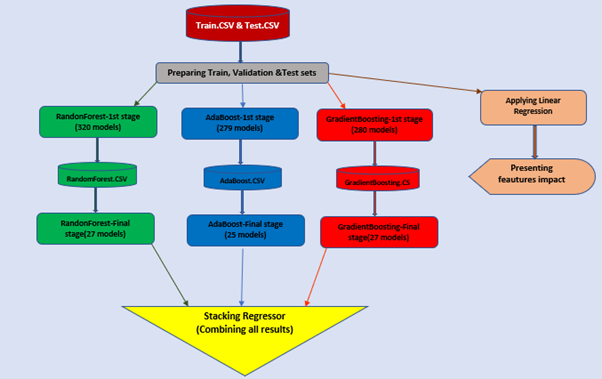

In [1]:
from IPython.display import Image 
Image(filename='./images/Project_Flowchart.png')

I have created several functions to help with implementing and tunning the hyperparameters used in different methods.

Please see below all the imported libraries at the begining of my coding(python standard, sklearn and my own libraries) which will be helping me to achieve the goal we have been tasked to get to in this project : 

In [2]:
import sys                     # import libraries
sys.path.append('.\Library')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm, trange
import os
from matplotlib.ticker import MaxNLocator
                         
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor\
                            , VotingRegressor, StackingRegressor     # import sklearn libraries 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import accuracy_score

from utils import rgb2gray, get_regression_data, visualise_regression_data# import our libraries
from assigning_library import read_csv_files, split_train_validation, split_features_labels, read_param
from regression_library import low_high_param, show_features_impact, plot_models, hyper_3_param_array, hyper_2_param_array


## Part 1(B) - Load in the training and test splits of the dataset :

Here, initially the two csv files are imported to variables using pandas.

Then, the train csv will be split to header, training and validation sets.

Also, the training and validation sets will be split further to seperate the wine features from the label(wine quality).

Likewise the test csv, will be split to features and label.

In [3]:
path_train_file = "./Data/winequality-red-train.csv"  # assigning the train.csv file path to a variable
path_test_file = "./Data/winequality-red-test.csv"  # assigning the test.csv file path to a variable

my_train_File, my_test_File = read_csv_files(path_train_file, path_test_file)  # reading the csv files using pandas
                                                                       
header, X_train, X_validation, Y_train, Y_validation\
= split_train_validation(my_train_File, split_rate=0.28)  # splitting the train.csv to train and validation arrays

X_test, Y_test = split_features_labels(my_test_File) # splitting the test.csv file to features and label arrays

In [4]:
wine_df = pd.read_csv("./Data/winequality-red-train.csv") # importing the train csv to a dataframe

wine_df.drop(['Unnamed: 0'], axis=1, inplace = True) # Dropping the index column

wine_df.info() # Here we can see the 11 features and the label(wine's quality) as mentioned above

&lt;class &#39;pandas.core.frame.DataFrame&#39;&gt;
RangeIndex: 1279 entries, 0 to 1278
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1279 non-null   float64
 1   volatile acidity      1279 non-null   float64
 2   citric acid           1279 non-null   float64
 3   residual sugar        1279 non-null   float64
 4   chlorides             1279 non-null   float64
 5   free sulfur dioxide   1279 non-null   float64
 6   total sulfur dioxide  1279 non-null   float64
 7   density               1279 non-null   float64
 8   pH                    1279 non-null   float64
 9   sulphates             1279 non-null   float64
 10  alcohol               1279 non-null   float64
 11  quality               1279 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 120.0 KB


## PART 2 - Fit the models on the Data Set and impove the models performance using ensembe methods : 

### Type of models and HyperParameters tuning : 

All models used in this project are in regression form.

RandomForest, AdaBoost and GradienBoost are the regression ensebmles which have been implemented in this project.

### RandomForest(First Stage) :

In [80]:
# assigning the starting, endingpoint and steps size taken to tune the HyperParameters

n_estimator_strarting_point = 100   # Initial n_estimator will be used as a hyperparameter
n_estimator_ending_point = 500      # The maximum n_estimator will be used as a hyperparameter
n_estimator_step_size = 100         # The step taken while tunning the n_estimator hyperparameter

max_features_starting_point = 2   # Initial max_features will be used as a hyperparameter
max_features_ending_point = 10    # The maximum max_features will be used as a hyperparameter
max_features_step_size = 1        # The step taken while tunning the max_features hyperparameter

max_depth_starting_point = 3    # Initial max_depth will be used as a hyperparameter
max_depth_ending_point = 40     # The maximum max_depth will be used as a hyperparameter
max_depth_step_size = 4         # The step taken while tunning the max_depth hyperparameter
     

In [81]:
print(hyper_3_param_array.__doc__)


    hyper_3_param_array function creates a 2 dimension array 
    which the rows are representing each model to be trained and 
    the columns are representing each of the 3 HyperParameters 
    chosen for the training
    


In [82]:
RandomForest_hyper_param_array = hyper_3_param_array(n_estimator_strarting_point, n_estimator_ending_point, n_estimator_step_size, 
                                          max_features_starting_point, max_features_ending_point, max_features_step_size,
                                          max_depth_starting_point, max_depth_ending_point, max_depth_step_size)


#adding the scores from all the models to an array to identify the best model
RandomForest_score_array = np.ones((RandomForest_hyper_param_array.shape[0],1))

In [83]:
### training and testing(through validation sets) all the models
for RandomForest_idx in trange(len(RandomForest_hyper_param_array)):
    # assigning an instance of a model
    randomforestregressor = RandomForestRegressor(n_estimators = int(RandomForest_hyper_param_array[RandomForest_idx,0]),
                    max_features = RandomForest_hyper_param_array[RandomForest_idx,1], 
                    max_depth = RandomForest_hyper_param_array[RandomForest_idx,2])
    
    randomforestregressor.fit(X_train, Y_train)  # fitting the train arrays to each RandomForest model
    
    Y_prediction = np.around(randomforestregressor.predict(X_validation)) #predicting using the validation set  
    
    RandomForest_score_array[RandomForest_idx,0] = accuracy_score(Y_validation, Y_prediction) * 100 #accuaracy score for each model

max_index = np.argmax(RandomForest_score_array[:,0])

100%|██████████| 320/320 [04:32<00:00,  1.17it/s]


In [84]:
#Summary of the best HyperParameters which will be implemented in next stage and the best accuracy score

os.system('cls')
print("\n               RandomForest performance ")
print("            --------------------------------")  # show the best model of RandomForest tested on validation set
print("Best Regressor Score for RandomForest : {:.2f}%".format(RandomForest_score_array[max_index,0])) 
print("Best Estimator number : ", RandomForest_hyper_param_array[max_index,0], "\nBest Features number : "
      , RandomForest_hyper_param_array[max_index,1], "\nbest_max_depth : ",RandomForest_hyper_param_array[max_index,2])

randomforest_best_parameters = np.array([RandomForest_hyper_param_array[max_index,0]
                              , RandomForest_hyper_param_array[max_index,1], RandomForest_hyper_param_array[max_index,2]])

#Exporting the best HyperPatrameters to the relevant csv file for further stages
np.savetxt('./Data/RandomForest_Regressor.csv', randomforest_best_parameters, fmt="%d", delimiter=",")


               RandomForest performance 
            --------------------------------
Best Regressor Score for RandomForest : 82.17%
Best Estimator number :  300 
Best Features number :  2 
best_max_depth :  15


In [85]:
#Here we calculate how many subplots we need and how many models are allocated to each subplot

number_of_subplots = int(((n_estimator_ending_point + n_estimator_step_size - n_estimator_strarting_point-1)/n_estimator_step_size))
models_in_each_plot = int(len(RandomForest_hyper_param_array)/number_of_subplots)
print("number of models in each subplot: ",models_in_each_plot, "   number of subplots: ", number_of_subplots)

number of models in each subplot:  80    number of subplots:  4


###### The best model will be shown on the plot with a Red colour Star, slightly larger than other models which are represented by a triangle each

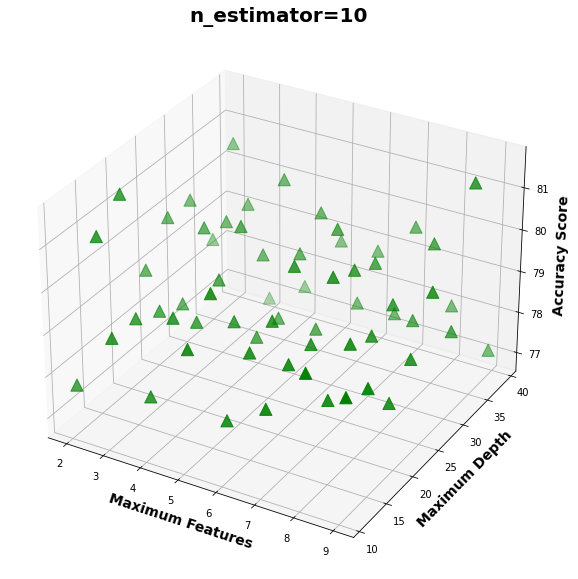

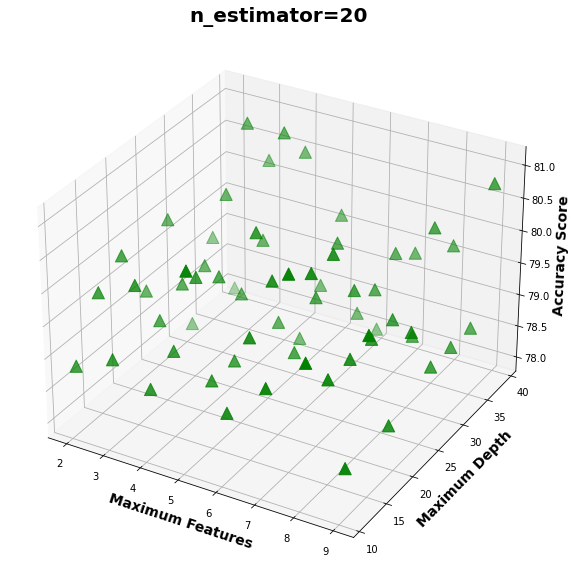

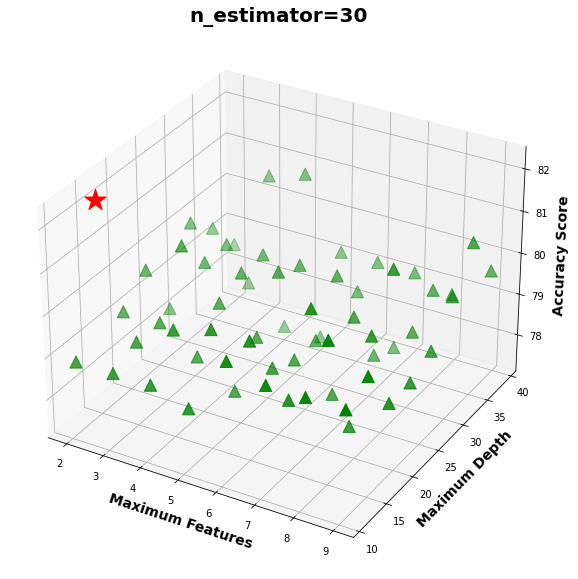

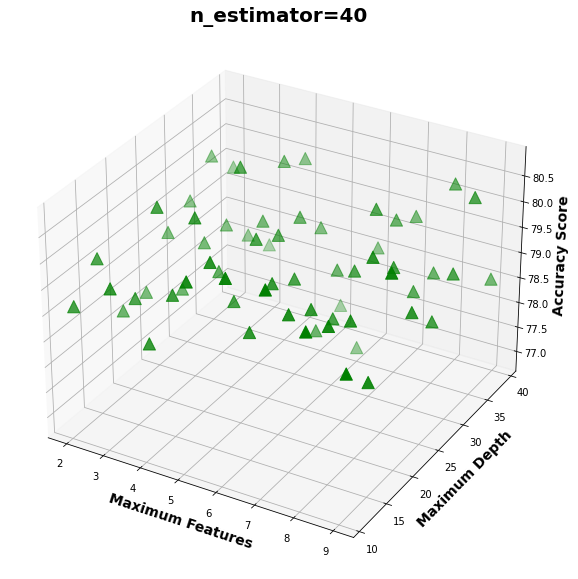

In [91]:
#Using scatter 3D plots to show the accuarcy of all the models

for subplot_idx in range(number_of_subplots): # Loop through each subplot
    
    #deciding the size and type of the plots
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    #creating an array for x-axis
    X = np.zeros((models_in_each_plot,))
    for i in range(models_in_each_plot):
        X[i] = RandomForest_hyper_param_array[i+subplot_idx*models_in_each_plot,1]
    
    #creating an array for y-axis
    Y = np.zeros((models_in_each_plot,))
    for i in range(models_in_each_plot):
        Y[i] = RandomForest_hyper_param_array[i+subplot_idx*models_in_each_plot,2]
    
    #creating and array for z-axis
    Z = np.zeros((models_in_each_plot,))
    for i in range(models_in_each_plot):
        Z[i] = RandomForest_score_array[i+subplot_idx*models_in_each_plot,0]

    #assigning the text and font size to the axis
    ax.set_xlabel('Maximum Features', fontsize=14, fontweight ='bold')
    ax.set_ylabel('Maximum Depth', fontsize=14, fontweight ='bold')
    ax.set_zlabel('Accuracy Score', fontsize=14, fontweight ='bold')
    
    #finding the best score
    zmax = np.max(RandomForest_score_array[:,0])
    
    #setting the scatter plot to only show the models with high accuracy for better visibility
    high_score =.9
    
    ax.set_title('n_estimator=%i' %(n_estimator_strarting_point+n_estimator_step_size*subplot_idx), fontsize =20, fontweight ='bold')
    
    #Plotting the models with small triangle shape
    ax.scatter(X[np.where((Z>zmax*high_score)&(Z<zmax))], Y[np.where((Z>zmax*high_score)&(Z<zmax))], 
           Z[np.where((Z>zmax*high_score)&(Z<zmax))], marker='^',c="green", s=150)
    
    #Plotting the best model with a Red star
    ax.scatter(X[Z==zmax], Y[Z==zmax], Z[Z==zmax], marker='*',c="red", s=500)

plt.show()

### AdaBoost(First Stage) :

In [87]:
# assigning the starting, endingpoint and steps size taken to tune the HyperParameters

n_estimator_strarting_point = 10   # Initial n_estimator will be used as a hyperparameter
n_estimator_ending_point = 100      # The maximum n_estimator will be used as a hyperparameter
n_estimator_step_size = 10         # The step taken while tunning the n_estimator hyperparameter


#The learning rate input are multiplied by 100 to keep it as integer in the nested Loop(So, 7 is learning rate of 0.07)
learning_rate_starting_point = 7   # Initial learning_rate will be used as a hyperparameter
learning_rate_ending_point = 100    # The maximum learning_rate will be used as a hyperparameter
learning_rate_step_size = 3        # The step taken while tunning the learning_rate hyperparameter

In [88]:
print(hyper_2_param_array.__doc__)


    hyper_2_param_array function creates a 2 dimension array 
    which the rows are representing each model to be trained and 
    the columns are representing each of the 2 HyperParameters 
    chosen for the training
    


In [89]:
AdaBoost_hyper_param_array = hyper_2_param_array(n_estimator_strarting_point, n_estimator_ending_point, n_estimator_step_size, 
                                          learning_rate_starting_point, learning_rate_ending_point, learning_rate_step_size)


#adding the scores from all the models to an array to identify the best model
AdaBoost_score_array = np.ones((AdaBoost_hyper_param_array.shape[0],1))

In [90]:
### training and testing(through validation sets) all the models
for AdaBoost_idx in trange(len(AdaBoost_hyper_param_array)):
    # assigning an instance of a model
    AdaBoostregressor = AdaBoostRegressor(n_estimators = int(AdaBoost_hyper_param_array[AdaBoost_idx,0]),
                        learning_rate = AdaBoost_hyper_param_array[AdaBoost_idx,1]/100)
    
    AdaBoostregressor.fit(X_train, Y_train)  # fitting the train arrays to each AdaBoost model
    
    Y_prediction = np.around(AdaBoostregressor.predict(X_validation)) #predicting using the validation set  
    
    AdaBoost_score_array[AdaBoost_idx,0] = accuracy_score(Y_validation, Y_prediction) * 100 #accuaracy score for each model

max_index = np.argmax(AdaBoost_score_array[:,0])

100%|██████████| 279/279 [00:43<00:00,  6.35it/s]


In [92]:
#Summary of the best HyperParameters which will be implemented in next stage and the best accuracy score

os.system('cls')
print("\n               AdaBoost performance ")
print("            --------------------------------")  # show the best model of AdaBoost tested on validation set
print("Best Regressor Score for AdaBoost : {:.2f}%".format(AdaBoost_score_array[max_index,0])) 
print("Best Estimator number : ", AdaBoost_hyper_param_array[max_index,0], "\nBest Learning_rate : "
      , AdaBoost_hyper_param_array[max_index,1]/100)

AdaBoost_best_parameters = np.array([AdaBoost_hyper_param_array[max_index,0]
                              , AdaBoost_hyper_param_array[max_index,1]])

#Exporting the best HyperPatrameters to the relevant csv file for further stages
np.savetxt('./Data/AdaBoost_Regressor.csv', AdaBoost_best_parameters, fmt="%d", delimiter=",")


               AdaBoost performance 
            --------------------------------
Best Regressor Score for AdaBoost : 63.23%
Best Estimator number :  80 
Best Learning_rate :  0.64


In [93]:
#Here we calculate how many models are allocated to the plot

number_of_estimators = int(((n_estimator_ending_point + n_estimator_step_size - n_estimator_strarting_point-1)/n_estimator_step_size))
total_models = int(len(AdaBoost_hyper_param_array))
print("Number of models : ",total_models)

Number of models :  279


###### The best model will be shown on the plot with a Red colour Star, slightly larger than other models which are represented by a triangle each

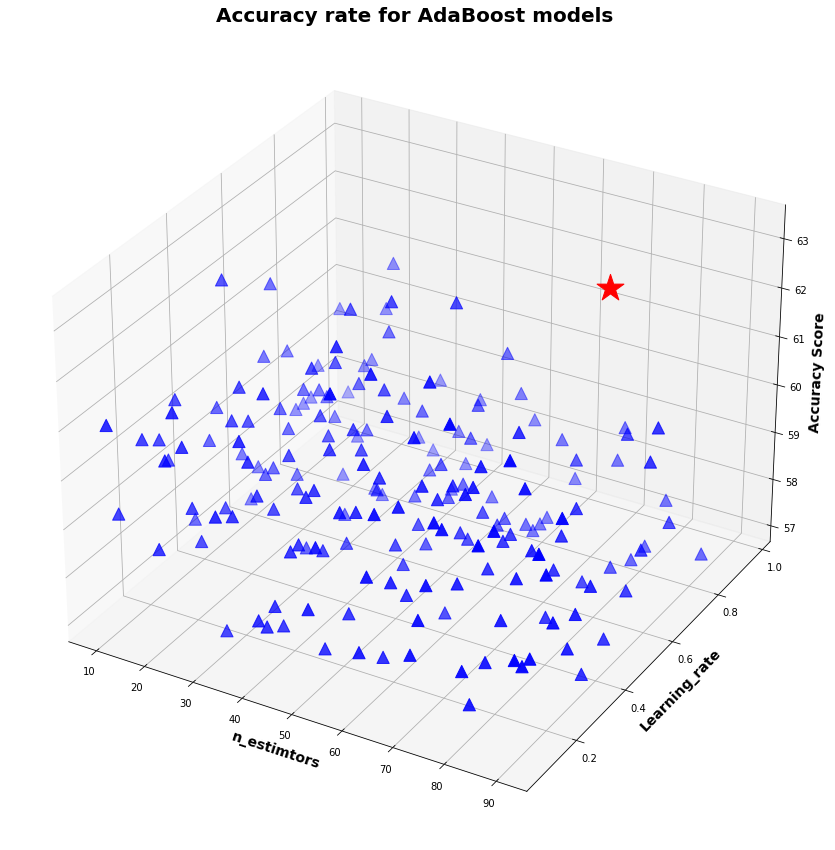

In [94]:
#Using scatter 3D plots to show the accuarcy of all the models

#deciding the size and type of the plots
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
    
#creating an array for x-axis
X = np.zeros((total_models,))
for i in range(total_models):
    X[i] = AdaBoost_hyper_param_array[i,0]
    
#creating an array for y-axis
Y = np.zeros((total_models,))
for i in range(total_models):
    Y[i] = AdaBoost_hyper_param_array[i,1]/100
    
#creating and array for z-axis
Z = np.zeros((total_models,))
for i in range(total_models):
    Z[i] = AdaBoost_score_array[i,0]
    
#assigning the text and font size to the axis
ax.set_xlabel('n_estimtors', fontsize=14, fontweight ='bold')
ax.set_ylabel('Learning_rate', fontsize=14, fontweight ='bold')
ax.set_zlabel('Accuracy Score', fontsize=14, fontweight ='bold')
    
#finding the best score
zmax = np.max(AdaBoost_score_array[:,0])
    
#setting the scatter plot to only show the models with high accuracy for better visibility
high_score =.9
    
ax.set_title('Accuracy rate for AdaBoost models', fontsize =20, fontweight ='bold')

#Plotting the models with small triangle shape
ax.scatter(X[np.where((Z>zmax*high_score)&(Z<zmax))], Y[np.where((Z>zmax*high_score)&(Z<zmax))], 
           Z[np.where((Z>zmax*high_score)&(Z<zmax))], marker='^',c="blue", s=150)
    
#Plotting the best model with a Red star
ax.scatter(X[Z==zmax], Y[Z==zmax], Z[Z==zmax], marker='*',c="red", s=800)

plt.show()

### GradientBoost(First Stage) :

In [95]:
# assigning the starting, endingpoint and steps size taken to tune the HyperParameters

n_estimator_strarting_point = 60   # Initial n_estimator will be used as a hyperparameter
n_estimator_ending_point = 130      # The maximum n_estimator will be used as a hyperparameter
n_estimator_step_size = 10         # The step taken while tunning the n_estimator hyperparameter

#The learning rate input are multiplied by 100 to keep it as integer in the nested Loop(So, 3 is learning rate of 0.03)
learning_rate_starting_point = 3   # Initial learning_rate will be used as a hyperparameter
learning_rate_ending_point = 50    # The maximum learning_rate will be used as a hyperparameter
learning_rate_step_size = 5        # The step taken while tunning the learning_rate hyperparameter

max_depth_starting_point = 3    # Initial max_depth will be used as a hyperparameter
max_depth_ending_point = 10     # The maximum max_depth will be used as a hyperparameter
max_depth_step_size = 2         # The step taken while tunning the max_depth hyperparameter
     

In [96]:
print(hyper_3_param_array.__doc__)


    hyper_3_param_array function creates a 2 dimension array 
    which the rows are representing each model to be trained and 
    the columns are representing each of the 3 HyperParameters 
    chosen for the training
    


In [97]:
GradientBoost_hyper_param_array = hyper_3_param_array(n_estimator_strarting_point, n_estimator_ending_point, n_estimator_step_size, 
                                          learning_rate_starting_point, learning_rate_ending_point, learning_rate_step_size,
                                          max_depth_starting_point, max_depth_ending_point, max_depth_step_size)


#adding the scores from all the models to an array to identify the best model
GradientBoost_score_array = np.ones((GradientBoost_hyper_param_array.shape[0],1))

In [98]:
### training and testing(through validation sets) all the models
for GradientBoost_idx in trange(len(GradientBoost_hyper_param_array)):
    # assigning an instance of a model
    gradientBoostregressor = GradientBoostingRegressor(n_estimators = int(GradientBoost_hyper_param_array[GradientBoost_idx,0]),
                    learning_rate = GradientBoost_hyper_param_array[GradientBoost_idx,1]/100, 
                    max_depth = GradientBoost_hyper_param_array[GradientBoost_idx,2])
    
    gradientBoostregressor.fit(X_train, Y_train)  # fitting the train arrays to each GradientBoost model
    
    Y_prediction = np.around(gradientBoostregressor.predict(X_validation)) #predicting using the validation set  
    
    GradientBoost_score_array[GradientBoost_idx,0] = accuracy_score(Y_validation, Y_prediction) * 100 #accuaracy score for each model

max_index = np.argmax(GradientBoost_score_array[:,0])

100%|██████████| 280/280 [01:35<00:00,  2.92it/s]


In [99]:
#Summary of the best HyperParameters which will be implemented in next stage and the best accuracy score

os.system('cls')
print("\n               GradientBoost performance ")
print("            --------------------------------")  # show the best model of GradientBoost tested on validation set
print("Best Regressor Score for GradientBoost : {:.2f}%".format(GradientBoost_score_array[max_index,0])) 
print("Best Estimator number : ", GradientBoost_hyper_param_array[max_index,0], "\nBest Learning_rate : "
      , GradientBoost_hyper_param_array[max_index,1]/100, "\nbest_max_depth : ",GradientBoost_hyper_param_array[max_index,2])

GradientBoost_best_parameters = np.array([GradientBoost_hyper_param_array[max_index,0]
                              , GradientBoost_hyper_param_array[max_index,1], GradientBoost_hyper_param_array[max_index,2]])

#Exporting the best HyperPatrameters to the relevant csv file for further stages
np.savetxt('./Data/GradientBoosting_Regressor.csv', GradientBoost_best_parameters, fmt="%d", delimiter=",")


               GradientBoost performance 
            --------------------------------
Best Regressor Score for GradientBoost : 83.29%
Best Estimator number :  90 
Best Learning_rate :  0.13 
best_max_depth :  7


In [100]:
#Here we calculate how many subplots we need and how many models are allocated to each subplot

number_of_subplots = int(((n_estimator_ending_point + n_estimator_step_size - n_estimator_strarting_point-1)/n_estimator_step_size))
models_in_each_plot = int(len(GradientBoost_hyper_param_array)/number_of_subplots)
print("number of models in each subplot: ",models_in_each_plot, "   number of subplots: ", number_of_subplots)

number of models in each subplot:  40    number of subplots:  7


###### The best model will be shown on the plot with a Red colour Star, slightly larger than other models which are represented by a triangle each

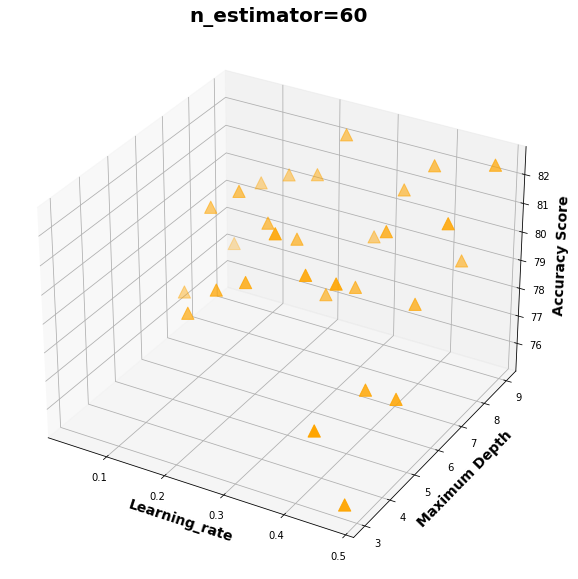

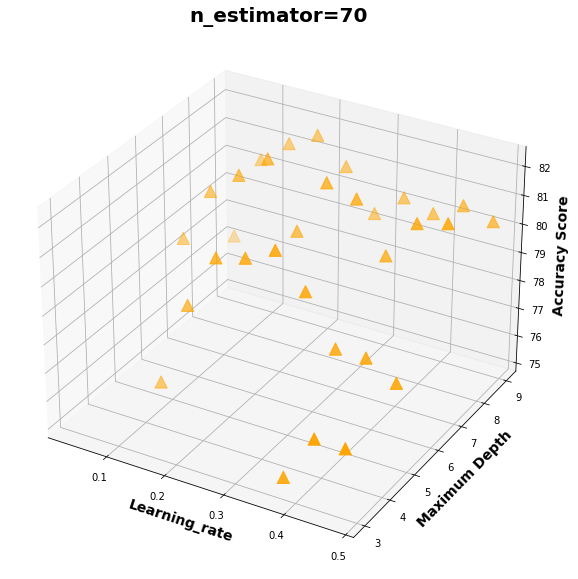

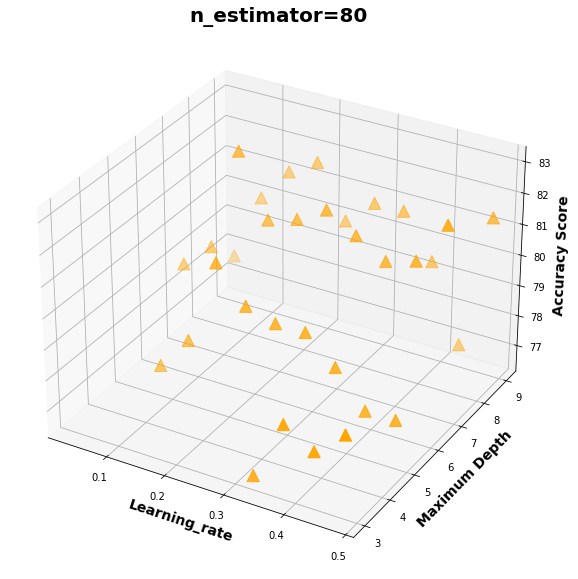

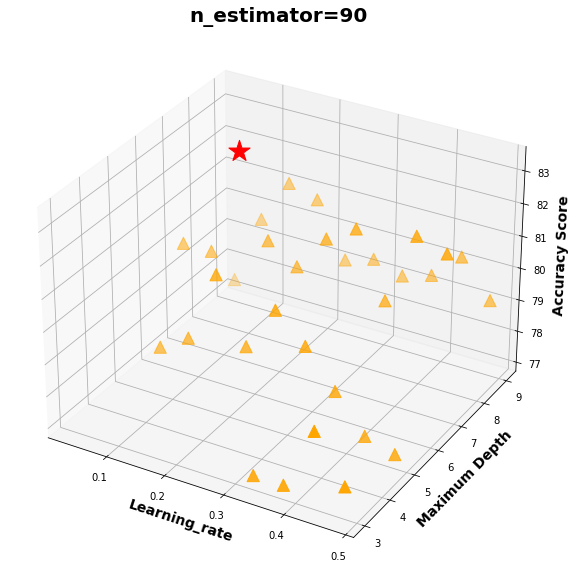

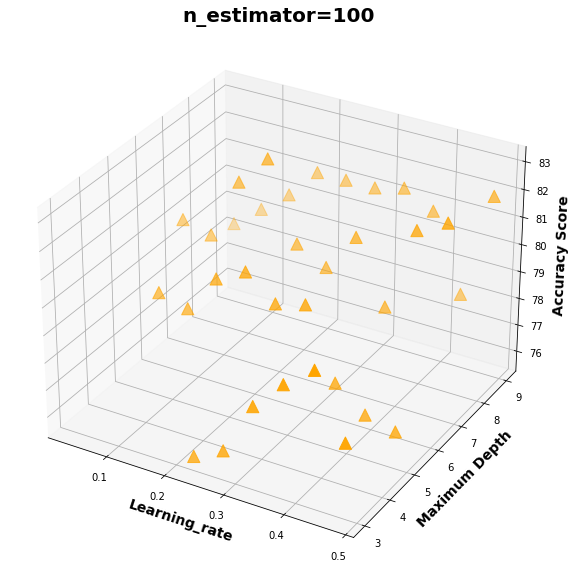

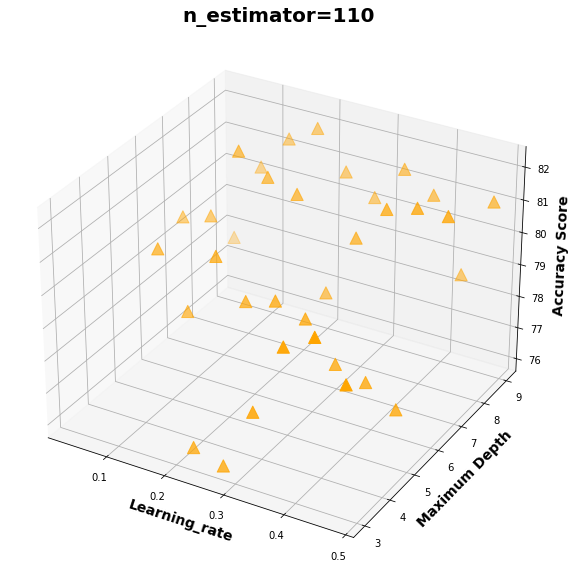

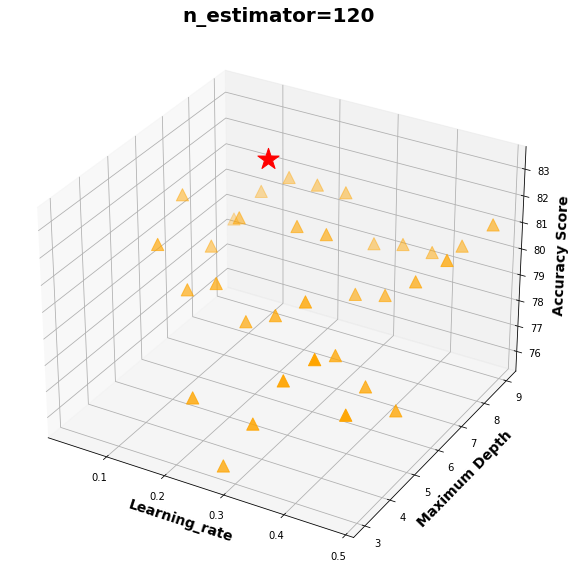

In [103]:
#Using scatter 3D plots to show the accuarcy of all the models

for subplot_idx in range(number_of_subplots): # Loop through each subplot
    
    #deciding the size and type of the plots
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    #creating an array for x-axis
    X = np.zeros((models_in_each_plot,))
    for i in range(models_in_each_plot):
        X[i] = GradientBoost_hyper_param_array[i+subplot_idx*models_in_each_plot,1]/100
    
    #creating an array for y-axis
    Y = np.zeros((models_in_each_plot,))
    for i in range(models_in_each_plot):
        Y[i] = GradientBoost_hyper_param_array[i+subplot_idx*models_in_each_plot,2]
    
    #creating and array for z-axis
    Z = np.zeros((models_in_each_plot,))
    for i in range(models_in_each_plot):
        Z[i] = GradientBoost_score_array[i+subplot_idx*models_in_each_plot,0]
    
    #assigning the text and font size to the axis
    ax.set_xlabel('Learning_rate', fontsize=14, fontweight ='bold')
    ax.set_ylabel('Maximum Depth', fontsize=14, fontweight ='bold')
    ax.set_zlabel('Accuracy Score', fontsize=14, fontweight ='bold')
    
    #finding the best score
    zmax = np.max(GradientBoost_score_array[:,0])
    
    #setting the scatter plot to only show the models with high accuracy for better visibility
    high_score =.9
    
    ax.set_title('n_estimator=%i' %(n_estimator_strarting_point+n_estimator_step_size*subplot_idx), fontsize =20, fontweight ='bold')
    
    #Plotting the models with small triangle shape
    ax.scatter(X[np.where((Z>zmax*high_score)&(Z<zmax))], Y[np.where((Z>zmax*high_score)&(Z<zmax))], 
           Z[np.where((Z>zmax*high_score)&(Z<zmax))], marker='^',c="orange", s=150)
    
    #Plotting the best model with a Red star
    ax.scatter(X[Z==zmax], Y[Z==zmax], Z[Z==zmax], marker='*',c="red", s=500)

plt.show()

## Part 3 - Improving the performance of the ensembles

### Further tunning to achive better models : 

The same 3 Regression ensembles have been used that was implemented earlier in Part 2.

However, the tunning will be more precise by using smaller steps around the best scores accieved from part 2 ensembles.

### RandomForest(2nd Stage):

In [5]:
n_estimator_midpoint, max_features_midpoint, max_depth_midpoint\
                = read_param("./Data/RandomForest_regressor.csv", 3) # reading the parameters from 1st stage of RandomForest

In [6]:
print(low_high_param.__doc__)


    low_high_param is a function which sets the lowest and
    highest figure that we want to tune our HyperParameters
    by getting the midpoint(which was the best HyperParameters)
    from previous stage.
    


In [7]:
n_estimator_step_size = 50 # defining the step change of n_estimator moving from one model to another
# finding lowest and highest values for n_estimators
n_estimator_strarting_point, n_estimator_ending_point = low_high_param(n_estimator_midpoint, n_estimator_step_size, 3) 

max_features_step_size = 1 # defining the step change of max_features moving from one model to another
# finding lowest and highest values for max_features of RandomForest
max_features_starting_point, max_features_ending_point = low_high_param(max_features_midpoint,max_features_step_size, 3) 
    
max_depth_step_size = 2 # defining the step change of max_depth moving from one model to another
# finding lowest and highest values for depth_features of RandomForest
max_depth_starting_point, max_depth_ending_point = low_high_param(max_depth_midpoint,max_depth_step_size, 3) 


In [20]:
print(hyper_3_param_array.__doc__)


    hyper_3_param_array function creates a 2 dimension array 
    which the rows are representing each model to be trained and 
    the columns are representing each of the 3 HyperParameters 
    chosen for the training
    


In [21]:
RandomForest_hyper_param_array = hyper_3_param_array(n_estimator_strarting_point, n_estimator_ending_point, n_estimator_step_size, 
                                          max_features_starting_point, max_features_ending_point, max_features_step_size,
                                          max_depth_starting_point, max_depth_ending_point, max_depth_step_size)


#adding the scores from all the models to an array to identify the best model
RandomForest_score_array = np.ones((RandomForest_hyper_param_array.shape[0],1))

In [22]:
### training and testing(through validation sets) all the models
for RandomForest_idx in trange(len(RandomForest_hyper_param_array)):
    # assigning an instance of a model
    randomforestregressor = RandomForestRegressor(n_estimators = int(RandomForest_hyper_param_array[RandomForest_idx,0]),
                    max_features = RandomForest_hyper_param_array[RandomForest_idx,1], 
                    max_depth = RandomForest_hyper_param_array[RandomForest_idx,2])
    
    randomforestregressor.fit(X_train, Y_train)  # fitting the train arrays to each RandomForest model
    
    Y_prediction = np.around(randomforestregressor.predict(X_validation)) #predicting using the validation set  
    
    RandomForest_score_array[RandomForest_idx,0] = accuracy_score(Y_validation, Y_prediction) * 100 #accuaracy score for each model

max_index = np.argmax(RandomForest_score_array[:,0])

100%|██████████| 27/27 [00:25&lt;00:00,  1.08it/s]


In [23]:
#Summary of the best HyperParameters which will be implemented in next stage and the best accuracy score

os.system('cls')
print("\n               RandomForest performance ")
print("            --------------------------------")  # show the best model of RandomForest tested on validation set
print("Best Regressor Score for RandomForest : {:.2f}%".format(RandomForest_score_array[max_index,0])) 
print("Best Estimator number : ", RandomForest_hyper_param_array[max_index,0], "\nBest Features number : "
      , RandomForest_hyper_param_array[max_index,1], "\nbest_max_depth : ",RandomForest_hyper_param_array[max_index,2])

randomforest_best_parameters = np.array([RandomForest_hyper_param_array[max_index,0]
                              , RandomForest_hyper_param_array[max_index,1], RandomForest_hyper_param_array[max_index,2]])

#Exporting the best HyperPatrameters to the relevant csv file for further stages
np.savetxt('./Data/RandomForest_Regressor.csv', randomforest_best_parameters, fmt="%d", delimiter=",")


               RandomForest performance 
            --------------------------------
Best Regressor Score for RandomForest : 80.78%
Best Estimator number :  300 
Best Features number :  1 
best_max_depth :  13


In [24]:
#Here we calculate how many subplots we need and how many models are allocated to each subplot

number_of_subplots = int(((n_estimator_ending_point + n_estimator_step_size - n_estimator_strarting_point-1)/n_estimator_step_size))
models_in_each_plot = int(len(RandomForest_hyper_param_array)/number_of_subplots)
print("number of models in each subplot: ",models_in_each_plot, "   number of subplots: ", number_of_subplots)

number of models in each subplot:  9    number of subplots:  3


###### The best model will be shown on the plot with a Red colour Star, slightly larger than other models which are represented by a triangle each

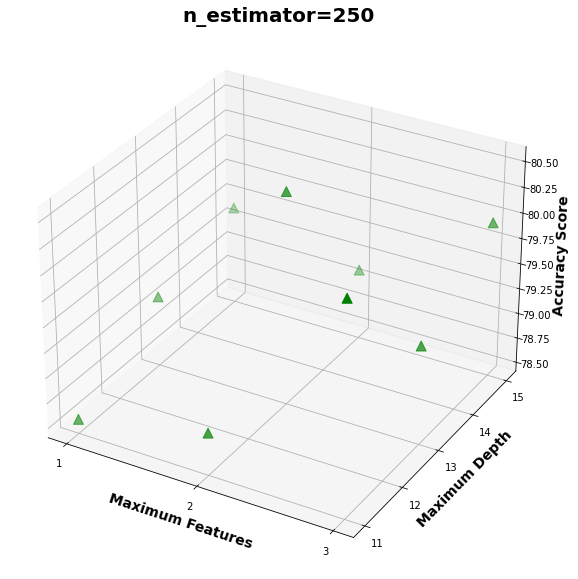

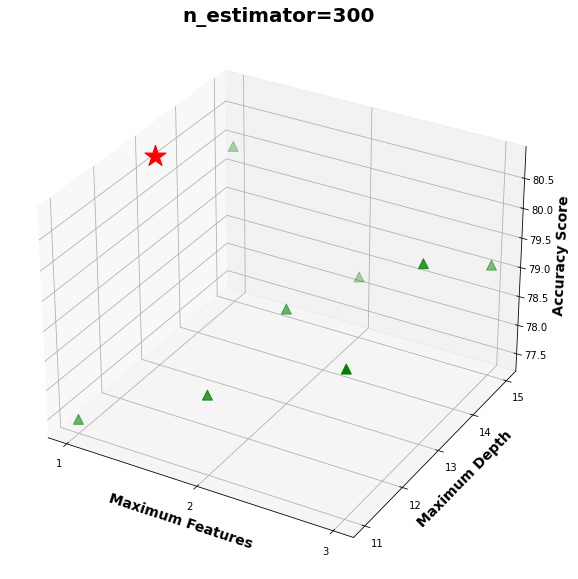

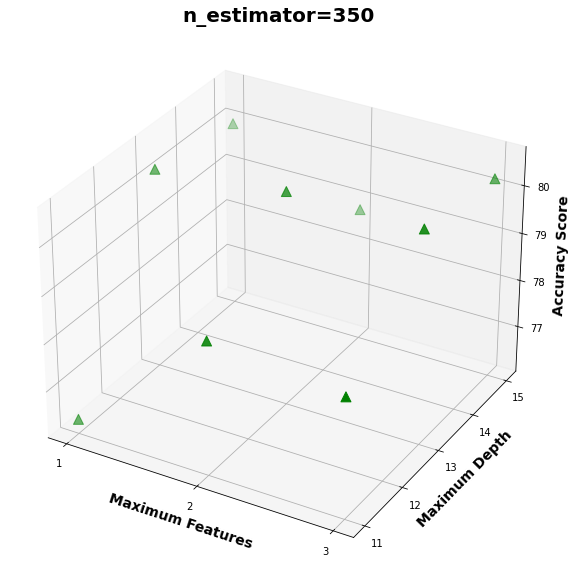

In [25]:
#Using scatter 3D plots to show the accuarcy of all the models

for subplot_idx in range(number_of_subplots): # Loop through each subplot
    
    #deciding the size and type of the plots
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    #creating an array for x-axis
    X = np.zeros((models_in_each_plot,))
    for i in range(models_in_each_plot):
        X[i] = RandomForest_hyper_param_array[i+subplot_idx*models_in_each_plot,1]
    
    #creating an array for y-axis
    Y = np.zeros((models_in_each_plot,))
    for i in range(models_in_each_plot):
        Y[i] = RandomForest_hyper_param_array[i+subplot_idx*models_in_each_plot,2]
    
    #creating and array for z-axis
    Z = np.zeros((models_in_each_plot,))
    for i in range(models_in_each_plot):
        Z[i] = RandomForest_score_array[i+subplot_idx*models_in_each_plot,0]

    #ensuring the axis are integer where float is meaningless
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    #assigning the text and font size to the axis
    ax.set_xlabel('Maximum Features', fontsize=14, fontweight ='bold')
    ax.set_ylabel('Maximum Depth', fontsize=14, fontweight ='bold')
    ax.set_zlabel('Accuracy Score', fontsize=14, fontweight ='bold')
    
    #finding the best score
    zmax = np.max(RandomForest_score_array[:,0])
    
    ax.set_title('n_estimator=%i' %(n_estimator_strarting_point+n_estimator_step_size*subplot_idx), fontsize =20, fontweight ='bold')
    
    #Plotting the models with small triangle shape
    ax.scatter(X[Z<zmax], Y[Z<zmax], Z[Z<zmax], marker='^',c="green", s=100)
    
    #Plotting the best model with a Red star
    ax.scatter(X[Z==zmax], Y[Z==zmax], Z[Z==zmax], marker='*',c="red", s=500)

plt.show()

### AdaBoost(2nd Stage):

In [26]:
 # reading the parameters from 1st stage of AdaBoost
n_estimator_midpoint, learning_rate_midpoint = read_param("./Data/AdaBoost_regressor.csv", 2)

In [27]:
print(low_high_param.__doc__)


    low_high_param is a function which sets the lowest and
    highest figure that we want to tune our HyperParameters
    by getting the midpoint(which was the best HyperParameters)
    from previous stage.
    


In [28]:
n_estimator_step_size = 3 # defining the step change of n_estimator moving from one model to another
# finding lowest and highest values for n_estimators
n_estimator_strarting_point, n_estimator_ending_point = low_high_param(n_estimator_midpoint, n_estimator_step_size, 2)

learning_rate_step_size = 1 # defining the step change of learning moving from one model to another
learning_rate_starting_point, learning_rate_ending_point = low_high_param\
(learning_rate_midpoint, learning_rate_step_size, 2) # finding lowest and highest values for learning_rate of AdaBoost

In [29]:
print(hyper_2_param_array.__doc__)


    hyper_2_param_array function creates a 2 dimension array 
    which the rows are representing each model to be trained and 
    the columns are representing each of the 2 HyperParameters 
    chosen for the training
    


In [30]:
AdaBoost_hyper_param_array = hyper_2_param_array(n_estimator_strarting_point, n_estimator_ending_point, n_estimator_step_size, 
                                          learning_rate_starting_point, learning_rate_ending_point, learning_rate_step_size)


#adding the scores from all the models to an array to identify the best model
AdaBoost_score_array = np.ones((AdaBoost_hyper_param_array.shape[0],1))

In [31]:
### training and testing(through validation sets) all the models
for AdaBoost_idx in trange(len(AdaBoost_hyper_param_array)):
    # assigning an instance of a model
    AdaBoostregressor = AdaBoostRegressor(n_estimators = int(AdaBoost_hyper_param_array[AdaBoost_idx,0]),
                        learning_rate = AdaBoost_hyper_param_array[AdaBoost_idx,1]/100)
    
    AdaBoostregressor.fit(X_train, Y_train)  # fitting the train arrays to each AdaBoost model
    
    Y_prediction = np.around(AdaBoostregressor.predict(X_validation)) #predicting using the validation set  
    
    AdaBoost_score_array[AdaBoost_idx,0] = accuracy_score(Y_validation, Y_prediction) * 100 #accuaracy score for each model

max_index = np.argmax(AdaBoost_score_array[:,0])

100%|██████████| 25/25 [00:08&lt;00:00,  3.03it/s]


In [32]:
#Summary of the best HyperParameters which will be implemented in next stage and the best accuracy score

os.system('cls')
print("\n               AdaBoost performance ")
print("            --------------------------------")  # show the best model of AdaBoost tested on validation set
print("Best Regressor Score for AdaBoost : {:.2f}%".format(AdaBoost_score_array[max_index,0])) 
print("Best Estimator number : ", AdaBoost_hyper_param_array[max_index,0], "\nBest Learning_rate : "
      , AdaBoost_hyper_param_array[max_index,1]/100)

AdaBoost_best_parameters = np.array([AdaBoost_hyper_param_array[max_index,0]
                              , AdaBoost_hyper_param_array[max_index,1]])

#Exporting the best HyperPatrameters to the relevant csv file for further stages
np.savetxt('./Data/AdaBoost_Regressor.csv', AdaBoost_best_parameters, fmt="%d", delimiter=",")


               AdaBoost performance 
            --------------------------------
Best Regressor Score for AdaBoost : 59.33%
Best Estimator number :  74 
Best Learning_rate :  0.65


In [33]:
#Here we calculate how many models are allocated to the plot

number_of_estimators = int(((n_estimator_ending_point + n_estimator_step_size - n_estimator_strarting_point-1)/n_estimator_step_size))
total_models = int(len(AdaBoost_hyper_param_array))
print("Number of models : ",total_models)

Number of models :  25


###### The best model will be shown on the plot with a Red colour Star, slightly larger than other models which are represented by a triangle each

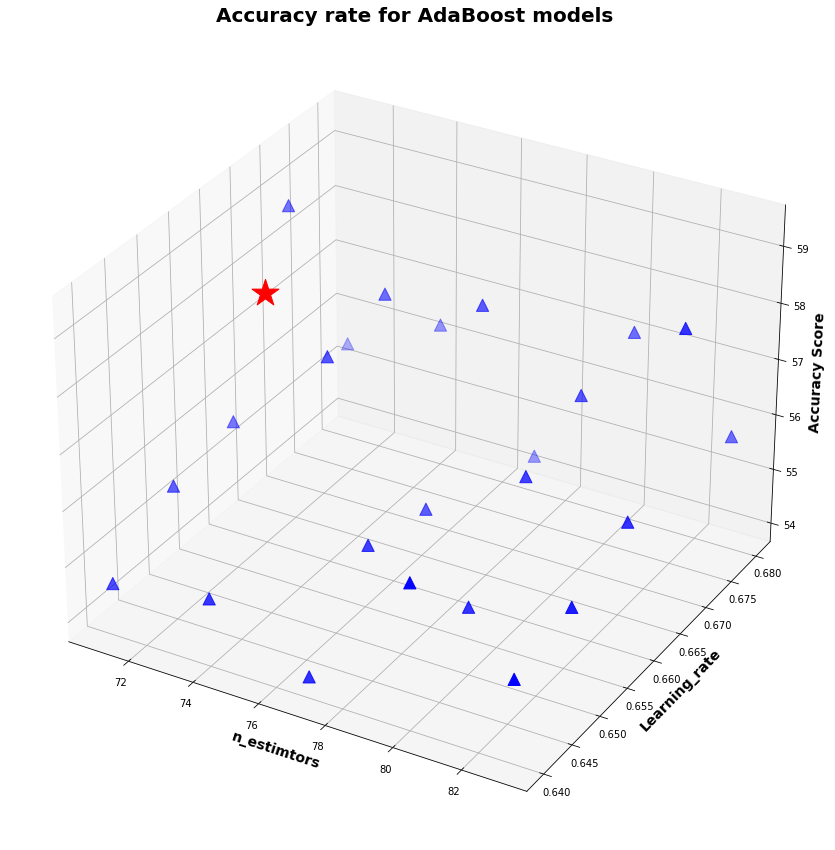

In [34]:
#Using scatter 3D plots to show the accuarcy of all the models

#deciding the size and type of the plots
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
    
#creating an array for x-axis
X = np.zeros((total_models,))
for i in range(total_models):
    X[i] = AdaBoost_hyper_param_array[i,0]
    
#creating an array for y-axis
Y = np.zeros((total_models,))
for i in range(total_models):
    Y[i] = AdaBoost_hyper_param_array[i,1]/100
    
#creating and array for z-axis
Z = np.zeros((total_models,))
for i in range(total_models):
    Z[i] = AdaBoost_score_array[i,0]

#ensuring the axis are integer where float is meaningless
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
#assigning the text and font size to the axis
ax.set_xlabel('n_estimtors', fontsize=14, fontweight ='bold')
ax.set_ylabel('Learning_rate', fontsize=14, fontweight ='bold')
ax.set_zlabel('Accuracy Score', fontsize=14, fontweight ='bold')
    
#finding the best score
zmax = np.max(AdaBoost_score_array[:,0])
    
ax.set_title('Accuracy rate for AdaBoost models', fontsize =20, fontweight ='bold')
    
#Plotting the models with small triangle shape
ax.scatter(X[Z<zmax], Y[Z<zmax], Z[Z<zmax], marker='^',c="blue", s=150)
    
#Plotting the best model with a Red star
ax.scatter(X[Z==zmax], Y[Z==zmax], Z[Z==zmax], marker='*',c="red", s=800)

plt.show()

### GradientBoosting(2nd Stage):

In [35]:
# reading the parameters from 1st stage of Gradientboosting
n_estimator_midpoint, learning_rate_midpoint, max_depth_midpoint = read_param("./Data/Gradientboosting_regressor.csv", 3) 

In [36]:
print(low_high_param.__doc__)


    low_high_param is a function which sets the lowest and
    highest figure that we want to tune our HyperParameters
    by getting the midpoint(which was the best HyperParameters)
    from previous stage.
    


In [37]:
n_estimator_step_size = 5 # defining the step change of n_estimator moving from one model to another
n_estimator_strarting_point, n_estimator_ending_point = low_high_param\
(n_estimator_midpoint, n_estimator_step_size, 3) # finding lowest and highest values for n_estimators of Gradientboosting

learning_rate_step_size = 2 # defining the step change of learning_rate moving from one model to another
learning_rate_starting_point, learning_rate_ending_point = low_high_param\
(learning_rate_midpoint,learning_rate_step_size, 3) # finding lowest and highest values for learning_rate of Gradientboosting
    
max_depth_step_size = 1 # defining the step change of max_depth moving from one model to another
max_depth_starting_point, max_depth_ending_point = low_high_param\
(max_depth_midpoint,max_depth_step_size, 3) # finding lowest and highest values for depth_features of Gradientboosting

In [38]:
print(hyper_3_param_array.__doc__)


    hyper_3_param_array function creates a 2 dimension array 
    which the rows are representing each model to be trained and 
    the columns are representing each of the 3 HyperParameters 
    chosen for the training
    


In [39]:
GradientBoost_hyper_param_array = hyper_3_param_array(n_estimator_strarting_point, n_estimator_ending_point, n_estimator_step_size, 
                                          learning_rate_starting_point, learning_rate_ending_point, learning_rate_step_size,
                                          max_depth_starting_point, max_depth_ending_point, max_depth_step_size)


#adding the scores from all the models to an array to identify the best model
GradientBoost_score_array = np.ones((GradientBoost_hyper_param_array.shape[0],1))

In [40]:
### training and testing(through validation sets) all the models
for GradientBoost_idx in trange(len(GradientBoost_hyper_param_array)):
    # assigning an instance of a model
    gradientBoostregressor = GradientBoostingRegressor(n_estimators = int(GradientBoost_hyper_param_array[GradientBoost_idx,0]),
                    learning_rate = GradientBoost_hyper_param_array[GradientBoost_idx,1]/100, 
                    max_depth = GradientBoost_hyper_param_array[GradientBoost_idx,2])
    
    gradientBoostregressor.fit(X_train, Y_train)  # fitting the train arrays to each GradientBoost model
    
    Y_prediction = np.around(gradientBoostregressor.predict(X_validation)) #predicting using the validation set  
    
    GradientBoost_score_array[GradientBoost_idx,0] = accuracy_score(Y_validation, Y_prediction) * 100 #accuaracy score for each model

max_index = np.argmax(GradientBoost_score_array[:,0])

100%|██████████| 27/27 [00:10&lt;00:00,  2.58it/s]


In [41]:
#Summary of the best HyperParameters which will be implemented in next stage and the best accuracy score

os.system('cls')
print("\n               GradientBoost performance ")
print("            --------------------------------")  # show the best model of GradientBoost tested on validation set
print("Best Regressor Score for GradientBoost : {:.2f}%".format(GradientBoost_score_array[max_index,0])) 
print("Best Estimator number : ", GradientBoost_hyper_param_array[max_index,0], "\nBest Learning_rate : "
      , GradientBoost_hyper_param_array[max_index,1]/100, "\nbest_max_depth : ",GradientBoost_hyper_param_array[max_index,2])

GradientBoost_best_parameters = np.array([GradientBoost_hyper_param_array[max_index,0]
                              , GradientBoost_hyper_param_array[max_index,1], GradientBoost_hyper_param_array[max_index,2]])

#Exporting the best HyperPatrameters to the relevant csv file for further stages
np.savetxt('./Data/GradientBoosting_Regressor.csv', GradientBoost_best_parameters, fmt="%d", delimiter=",")


               GradientBoost performance 
            --------------------------------
Best Regressor Score for GradientBoost : 84.12%
Best Estimator number :  90 
Best Learning_rate :  0.13 
best_max_depth :  6


In [42]:
#Here we calculate how many subplots we need and how many models are allocated to each subplot

number_of_subplots = int(((n_estimator_ending_point + n_estimator_step_size - n_estimator_strarting_point-1)/n_estimator_step_size))
models_in_each_plot = int(len(GradientBoost_hyper_param_array)/number_of_subplots)
print("number of models in each subplot: ",models_in_each_plot, "   number of subplots: ", number_of_subplots)

number of models in each subplot:  9    number of subplots:  3


###### The best model will be shown on the plot with a Red colour Star, slightly larger than other models which are represented by a triangle each

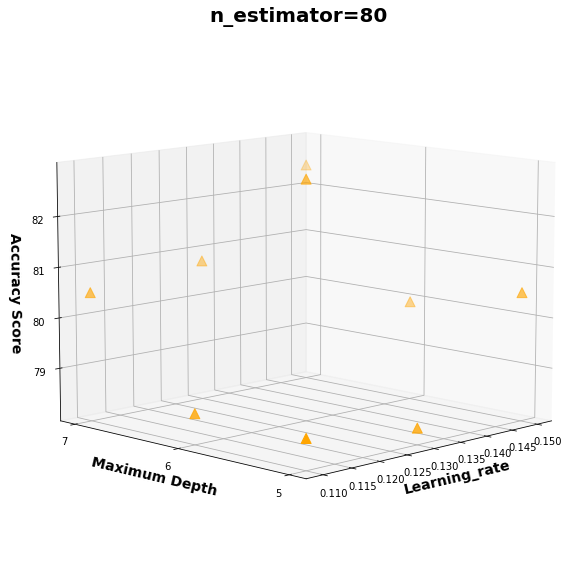

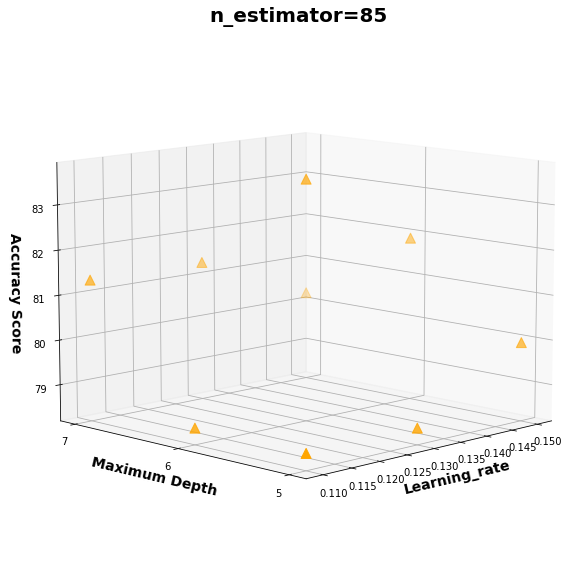

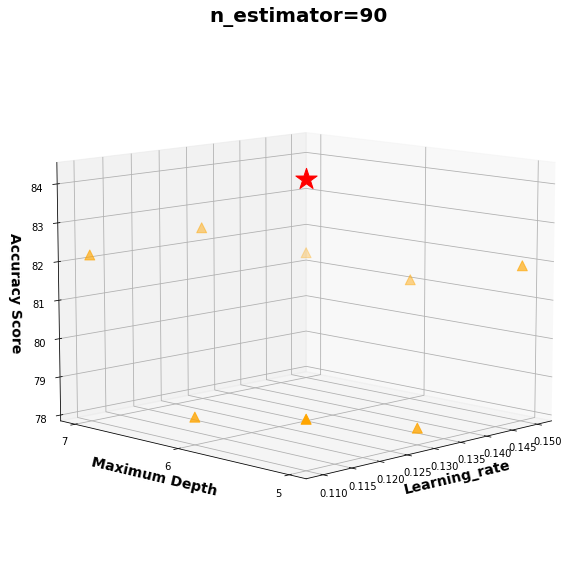

In [43]:
#Using scatter 3D plots to show the accuarcy of all the models

for subplot_idx in range(number_of_subplots): # Loop through each subplot
    
    #deciding the size and type of the plots
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    #creating an array for x-axis
    X = np.zeros((models_in_each_plot,))
    for i in range(models_in_each_plot):
        X[i] = GradientBoost_hyper_param_array[i+subplot_idx*models_in_each_plot,1]/100
    
    #creating an array for y-axis
    Y = np.zeros((models_in_each_plot,))
    for i in range(models_in_each_plot):
        Y[i] = GradientBoost_hyper_param_array[i+subplot_idx*models_in_each_plot,2]
    
    #creating and array for z-axis
    Z = np.zeros((models_in_each_plot,))
    for i in range(models_in_each_plot):
        Z[i] = GradientBoost_score_array[i+subplot_idx*models_in_each_plot,0]
    
    #ensuring the axis are integer where float is meaningless
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    #assigning the text and font size to the axis
    ax.set_xlabel('Learning_rate', fontsize=14, fontweight ='bold')
    ax.set_ylabel('Maximum Depth', fontsize=14, fontweight ='bold')
    ax.set_zlabel('Accuracy Score', fontsize=14, fontweight ='bold')
    
    #finding the best score
    zmax = np.max(GradientBoost_score_array[:,0])
        
    ax.set_title('n_estimator=%i' %(n_estimator_strarting_point+n_estimator_step_size*subplot_idx), fontsize =20, fontweight ='bold')
    
    #Plotting the models with small triangle shape
    ax.scatter(X[Z<zmax], Y[Z<zmax], Z[Z<zmax], marker='^',c="orange", s=100)
    
    #Plotting the best model with a Red star
    ax.scatter(X[Z==zmax], Y[Z==zmax], Z[Z==zmax], marker='*',c="red", s=500)
    ax.view_init(10,225)
    plt.draw()
plt.show()

## Part 4: Algorithm to find the best combination of models and hyperparameters

At final stage of ensembling, all three ensembles models : RandomForest, AdaBoost and GradientBoosting has been combined using StackingRegressor.

Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator(A regressor which will be used to combine the base estimators).

In Parts 2&3 the best HyperParameters have been found for each of ensemble model after using 1000s of estimotors.

The best HyperParameters found in previous parts are being implemented in the three ensemble models to combine them with StackingRegressor method.

Please see below the accuracy score for applying and running the code for the StackingRegressor method on the validation sets:

In [44]:
######### Assigning the best performed HyperParameters in the RandomForest, AdaBoost and GradientBoosting ##########
reg1 = RandomForestRegressor(n_estimators = randomforest_best_parameters[0],
          max_features = randomforest_best_parameters[1], max_depth = randomforest_best_parameters[2])
reg2 = AdaBoostRegressor(n_estimators = AdaBoost_best_parameters[0],  learning_rate = AdaBoost_best_parameters[1]/100)
reg3 = GradientBoostingRegressor(n_estimators = GradientBoost_best_parameters[0],
      learning_rate = GradientBoost_best_parameters[1]/100, max_depth = GradientBoost_best_parameters[2])

os.system('cls')
print("\n               StackingRegressor performance on validation sets ")
print("            ----------------------------------------------------------")
stackingregressor = StackingRegressor(estimators=[('rf1', reg1), ('ad1', reg2), ('gb1', reg3)])
stackingregressor = stackingregressor.fit(X_train, Y_train)        ### Fitting the StackingRegressor model #####  
Y_pred = np.around(stackingregressor.predict(X_validation)) ##### Predicting the Labels based on the validation features #####
ensemble_score = accuracy_score(Y_validation, Y_pred)  ##### Calulating the accuracy of each model ####

print("Regressor Score for StackingRegressor : {:.2f}%".format(ensemble_score*100))  ## showing the ensemble score ##
    


               StackingRegressor performance on validation sets 
            ----------------------------------------------------------
Regressor Score for StackingRegressor : 83.29%


Please see below applying the StackingRegressor method on the test sets :

In [45]:
print("\n              StackingRegressor performance on test sets ")
print("            ---------------------------------------------------")

Y_pred = np.around(stackingregressor.predict(X_test)) ##### Predicting the Labels based on the test features #####
ensemble_score = accuracy_score(Y_test, Y_pred)  ##### Calulating the accuracy of each model ####

print("Regressor Score for StackingRegressor : {:.2f}%".format(ensemble_score*100))  ## showing the ensemble score ##


              StackingRegressor performance on test sets 
            ---------------------------------------------------
Regressor Score for StackingRegressor : 67.61%


## Part 5 Presenting the results: 

Please see the graphs in all 3 ensemble models(1st and 2nd stage) in Parts 2 and 3 of this notebook.

AdaBoost is extremely sensitive to Noisy data and outliers. So, this could have an impact in getting a lower accuracy result in comparison to GradientBoost and RandomForest.

The StackingRegressor has accuracy score in range of (80%-85%) on the validation sets, however the accuracy score on the test sets is in range of (65%-70%). 

## Part 6  Most effective features(Ranked) :

LinearRegression model has been applied to training set to obtain the most affective features.

The result is ranked by most effective(which can have negative and positive impact in the quality of the wine we are testing) features impacting the red wine quality.

Alchohol and Sulphates respectively have the highest positve impact on the quality of the Red wine.

The Total sulfur dioxide, volatile acidity and cholrides have negative impact on the quality of the Red wine.

Other six features do not seem to have a great impact on the quality of the Red wine.

Please run the code below to see the result :



In [ ]:
os.system('cls')
linearregression = LinearRegression()
linearregression.fit(X_train, Y_train) ### Fitting the LinearRegression model #####

Y_pred = np.around(linearregression.predict(X_validation))  ##### Predicting the Labels based on the validation features #####
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
######## Showing the list of features ranked based the the impact to the prediction ############
show_features_impact(linearregression.coef_, X_train, header)
